In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2 
import glob
import random
from os import listdir
from sklearn.metrics import classification_report
import tensorflow as tf
import keras.utils as image
from PIL import Image
from tensorflow.keras.utils import to_categorical
breast_img = glob.glob('/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/**/*.png', recursive = True)

for imgname in breast_img[:3]:
    print(imgname)


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1351_y1101_class0.png
/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1501_y501_class0.png
/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1501_y1101_class0.png


# **DATA VISUALISATION**

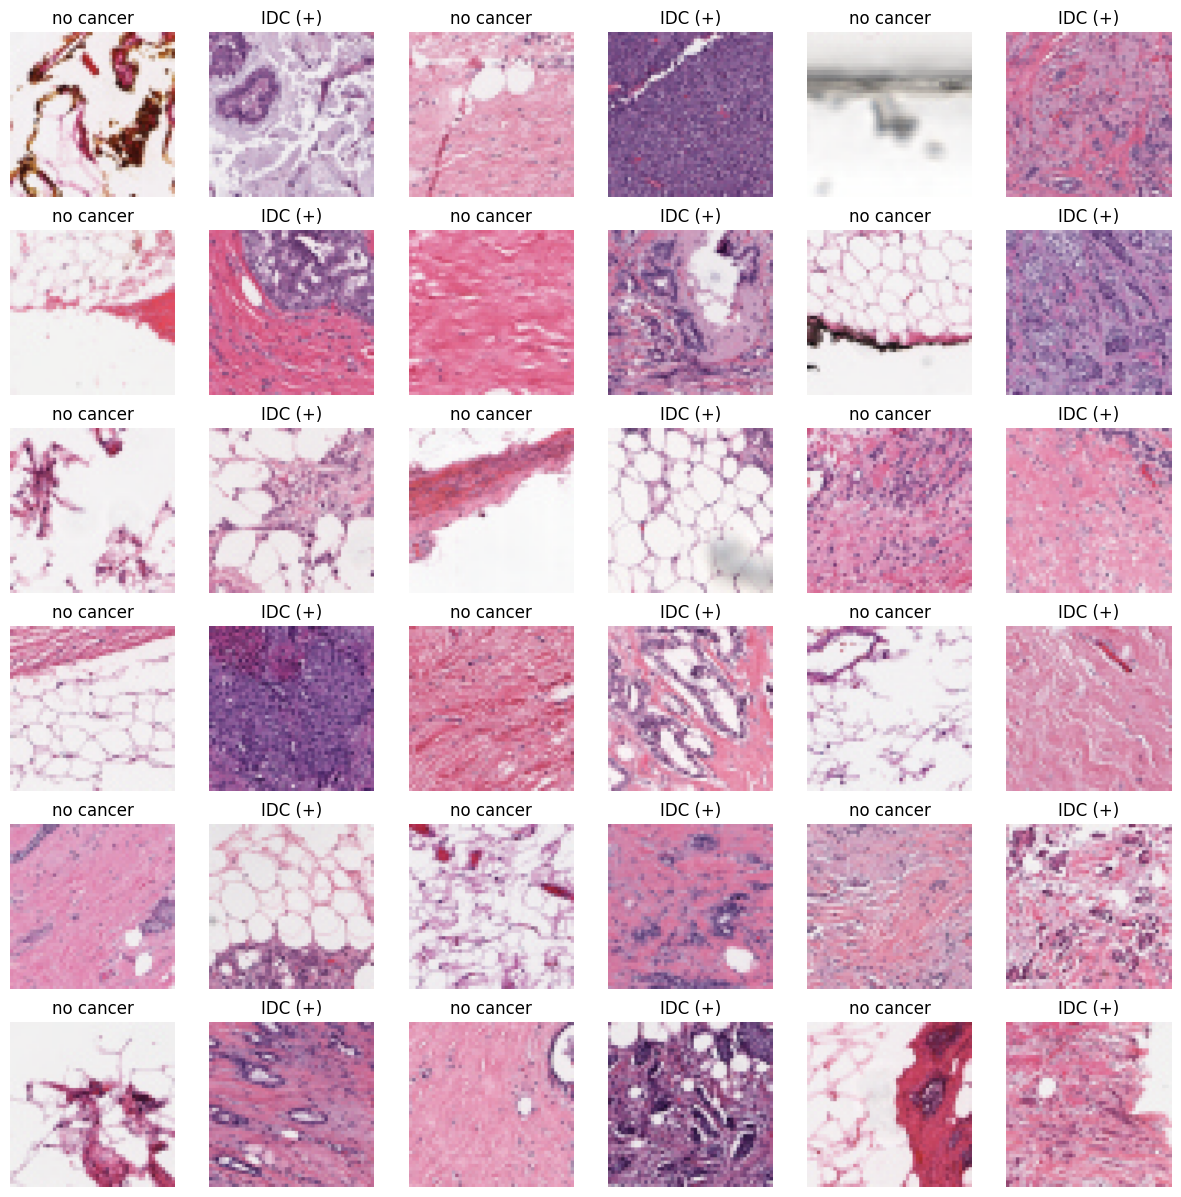

In [2]:
N_IDC = []
P_IDC = []

for img in breast_img:
    if img[-5] == '0' :
        N_IDC.append(img)
    
    elif img[-5] == '1' :
        P_IDC.append(img)
plt.figure(figsize = (15, 15))

some_non = np.random.randint(0, len(N_IDC), 18)
some_can = np.random.randint(0, len(P_IDC), 18)

s = 0
for num in some_non:
    
        img = image.load_img((N_IDC[num]), target_size=(100, 100))
        img = image.img_to_array(img)
        
        plt.subplot(6, 6, 2*s+1)
        plt.axis('off')
        plt.title('no cancer')
        plt.imshow(img.astype('uint8'))
        s += 1
s = 1
for num in some_can:
    
        img = image.load_img((P_IDC[num]), target_size=(100, 100))
        img = image.img_to_array(img)
        
        plt.subplot(6, 6, 2*s)
        plt.axis('off')        
        plt.title('IDC (+)')
        plt.imshow(img.astype('uint8'))
        s += 1

>  Visualisation des tissus en general 

**Cancerous vs non cancerous**

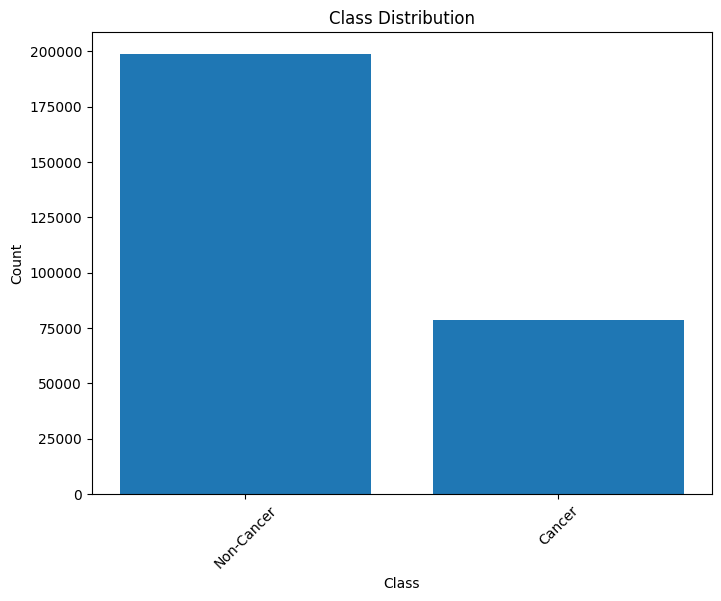

In [3]:
class_labels = ["Non-Cancer", "Cancer"]
class_counts = [len(N_IDC), len(P_IDC)]

plt.figure(figsize=(8, 6))
plt.bar(class_labels, class_counts)
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class Distribution")
plt.xticks(rotation=45)
plt.show()

there is a huge difference between the two classes, we better reduce the Non-cancer data to avoid the model being overtrained in this class, we will stop at 150 000 images

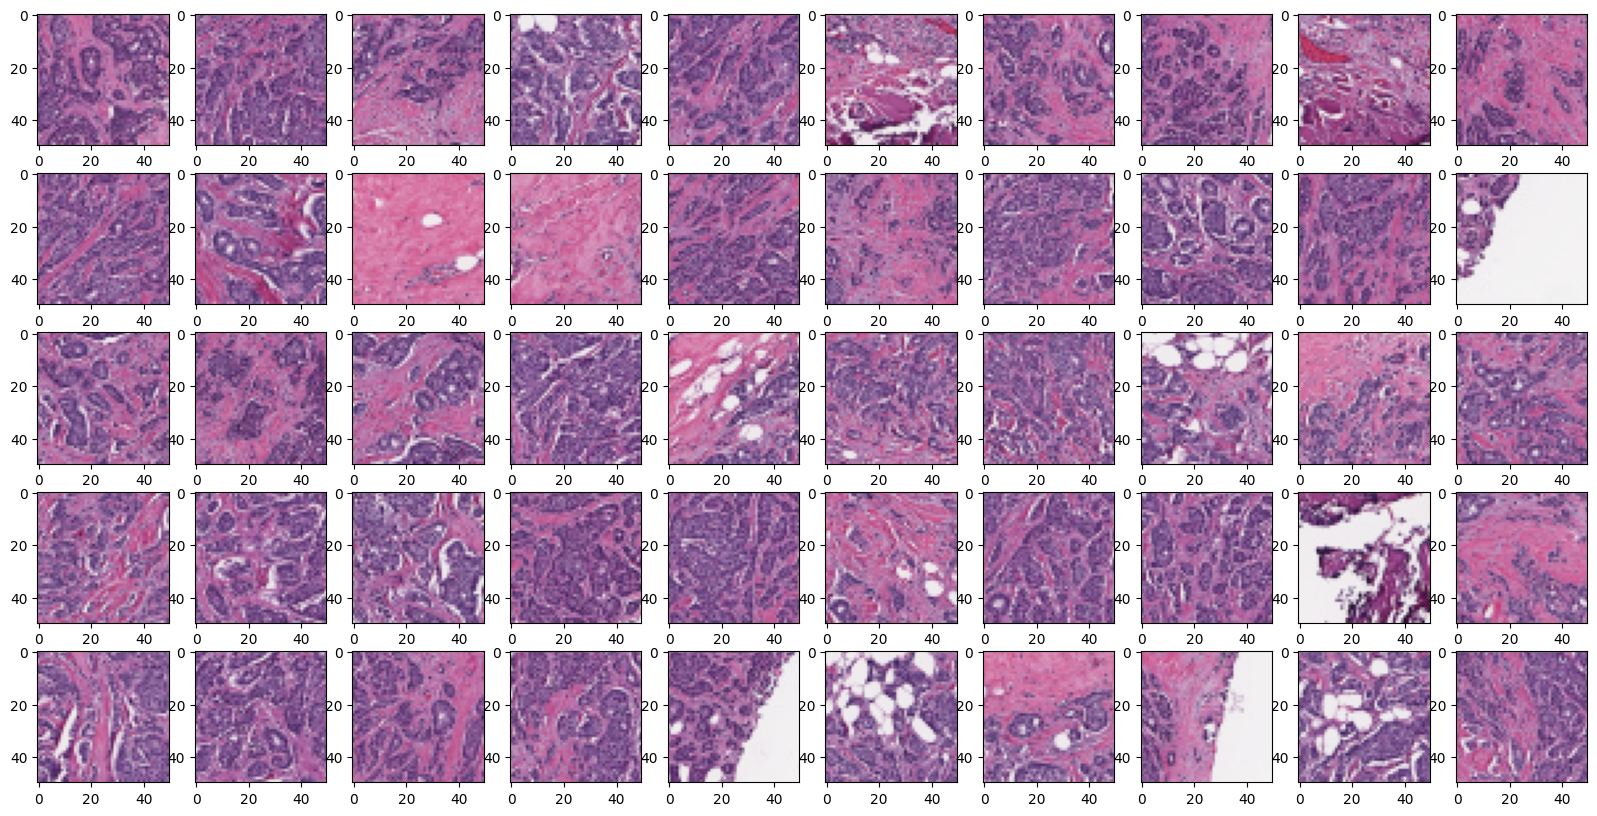

In [4]:

fig, ax = plt.subplots(5, 10, figsize=(20, 10))

for n in range(5):
    for m in range(10):
        idx = P_IDC[m + 10 * n]
        image = Image.open(idx)
        ax[n, m].imshow(image)
        ax[n, m].grid(False)

plt.show()



> Visualisation des tissus cancereux 

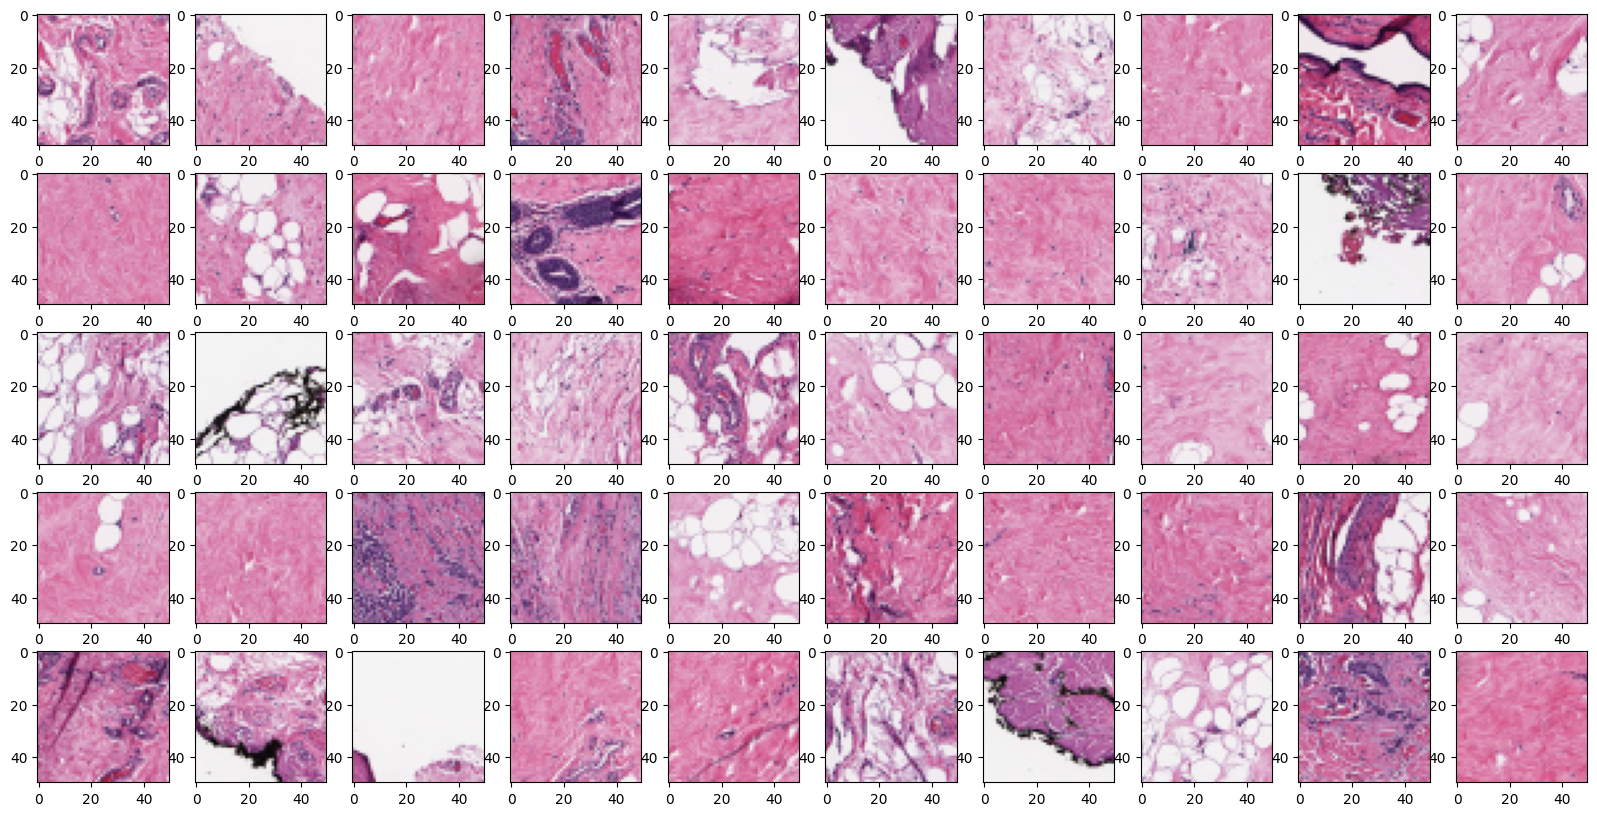

In [5]:

fig, ax = plt.subplots(5, 10, figsize=(20, 10))

for n in range(5):
    for m in range(10):
        idx = N_IDC[m + 10 * n]
        image = Image.open(idx)
        ax[n, m].imshow(image)
        ax[n, m].grid(False)

plt.show()

> Visualisation des tissus non cancereux 

In [6]:
print(len(N_IDC))
print(len(P_IDC))

198738
78786


In [7]:
NewN_IDC=N_IDC[:78786]

> ***On va essayer le model sur un petit echantillon et voir une accuracy approximative, trop de temps pour compiler une grande quantité de data***

In [8]:
images=[]
labels=[]
for i in breast_img[:15000]:
    if i.endswith('.png'):
        label=i[-5] #le 5eme indice a partir de la fin indique quelle classe appartient le model
        img=cv2.imread(i)
        img_1=cv2.resize(img,(100,100))
        images.append(img_1)
        labels.append(label)

> lire les images et les resize a 100. creer les prochaines avant data split 

In [9]:
x=np.stack(images) #mettre tout dans une seule liste
y=to_categorical(labels) #repartir les labels en deux classes

# Data split 

In [19]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rotation_range=20, zoom_range=0.15,
                             width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
                             horizontal_flip=True, fill_mode="nearest")

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)
datagen.flow

<bound method ImageDataGenerator.flow of <keras.preprocessing.image.ImageDataGenerator object at 0x792e22165000>>

# Simple CNN with EfficientNetB0 pre entrained as a base 

In [20]:
from tensorflow.keras.layers import Dense,Dropout,BatchNormalization,Conv2D,MaxPool2D,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
#Création du modèle séquentiel
model = Sequential()

#Première couche de convolution avec 32 filtres et une fenêtre de (3,3) et une activation ReLU
model.add(Conv2D(32, (3, 3), input_shape=(100, 100, 3), activation='relu'))

#Couche de pooling (max pooling) pour réduire la dimension
model.add(MaxPooling2D(pool_size=(2, 2))),

#Deuxième couche de convolution avec 64 filtres et une fenêtre de (3,3) et une activation ReLU
model.add(Conv2D(64, (3, 3), activation='relu'))

#Couche de pooling (max pooling) pour réduire la dimension
model.add(MaxPooling2D(pool_size=(2, 2)))

#Aplatir les données en un vecteur
model.add(Flatten())

#Couche dense (fully connected) avec 128 neurones et une activation ReLU
model.add(Dense(128, activation='relu'))

#Dropout pour la régularisation
model.add(Dropout(0.5))

#Couche de sortie avec 2 neurones (pour une classification binaire) et une activation sigmoïde
model.add(Dense(2, activation='sigmoid'))

#Compilation du modèle
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [21]:
from keras.optimizers import Adam

# Configuration de l'optimiseur
opt = Adam(learning_rate=0.01)

# Compilation du modèle
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

Training the model.

In [23]:
history=model.fit(x,y,epochs=10,validation_split=0.4,batch_size=56)

Epoch 1/10
161/161 [==============================] - 3s 16ms/step - loss: 0.5869 - accuracy: 0.7266 - val_loss: 0.6163 - val_accuracy: 0.6953
Epoch 2/10
161/161 [==============================] - 2s 15ms/step - loss: 0.5868 - accuracy: 0.7266 - val_loss: 0.6167 - val_accuracy: 0.6953
Epoch 3/10
161/161 [==============================] - 3s 16ms/step - loss: 0.5867 - accuracy: 0.7266 - val_loss: 0.6156 - val_accuracy: 0.6953
Epoch 4/10
161/161 [==============================] - 2s 15ms/step - loss: 0.5869 - accuracy: 0.7266 - val_loss: 0.6171 - val_accuracy: 0.6953
Epoch 5/10
161/161 [==============================] - 3s 17ms/step - loss: 0.5868 - accuracy: 0.7266 - val_loss: 0.6176 - val_accuracy: 0.6953
Epoch 6/10
161/161 [==============================] - 2s 15ms/step - loss: 0.5869 - accuracy: 0.7266 - val_loss: 0.6181 - val_accuracy: 0.6953
Epoch 7/10
161/161 [==============================] - 3s 16ms/step - loss: 0.5869 - accuracy: 0.7266 - val_loss: 0.6175 - val_accuracy: 0.6953

In [24]:
loss,accuracy=model.evaluate(x_test,y_test)

94/94 [==============================] - 1s 5ms/step - loss: 0.6009 - accuracy: 0.7123


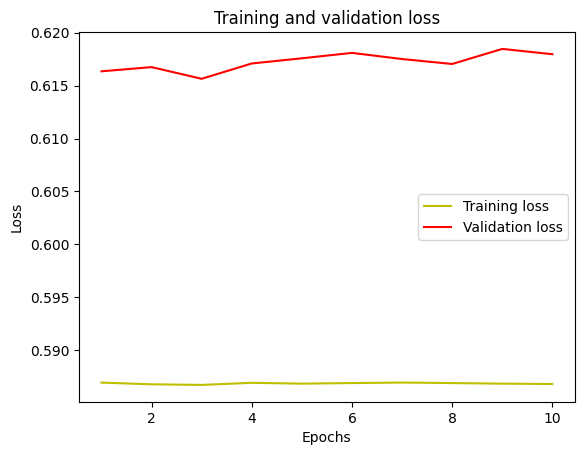

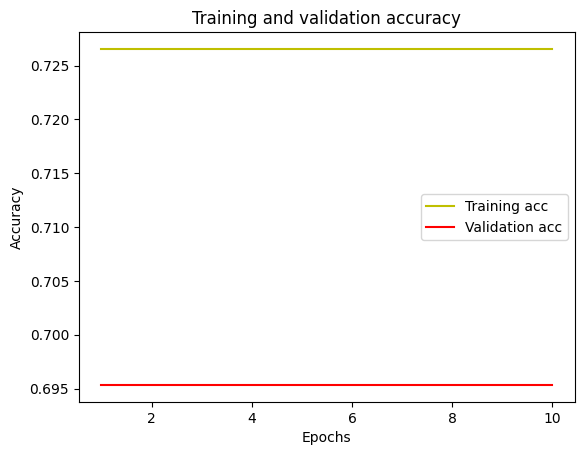

In [25]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['accuracy']  #Use accuracy if acc doesn't work
val_acc = history.history['val_accuracy']  #Use val_accuracy if acc doesn't work
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [26]:
print(round(accuracy,5))

0.71233
